In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
%matplotlib inline

In [2]:
#impoting all images from both folders
female = glob('cropped_female/*.png')
male = glob('cropped_male/*.png')

In [3]:
both = female + male

In [4]:
both[:3]

['cropped_female\\female_0.png',
 'cropped_female\\female_1.png',
 'cropped_female\\female_100.png']

In [5]:
def getSize(file):
    # go through every image and return the size 
    img = Image.open(file)
    return img.size[0]

In [6]:
# Create a dataframe
df = pd.DataFrame(data=both, columns=['path'])

In [7]:
# Apply the function to return the size of every image
df['size'] = df['path'].apply(getSize)

In [8]:
df.describe()

,size
count,5293.000000
mean,158.331570
std,70.731099
min,36.000000
25%,122.000000
50%,182.000000
75%,182.000000
max,410.000000


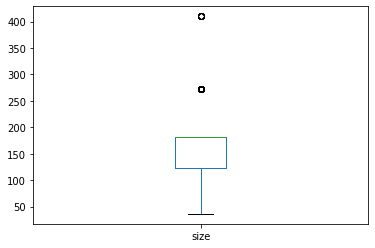

In [9]:
df['size'].plot(kind='box')

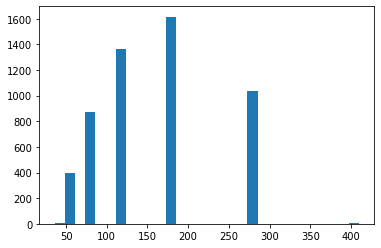

In [10]:
plt.hist(df['size'],bins=30)
plt.show()

In [11]:
# split the string to find the labels
string = df['path'][0]

In [12]:
string

'cropped_female\\female_0.png'

In [13]:
string.split('\\')[0].split('_')[1]

'female'

In [14]:
def gender(string):
    try:
        return string.split('\\')[0].split('_')[1]
    except:
        return None

In [15]:
# Apply the function to find the labels
df['gender'] = df['path'].apply(gender)

In [16]:
df

,path,size,gender
0,cropped_female\female_0.png,273,female
1,cropped_female\female_1.png,182,female
2,cropped_female\female_100.png,182,female
3,cropped_female\female_1003.png,182,female
4,cropped_female\female_1008.png,81,female
...,...,...,...
5288,cropped_male\male_989.png,182,male
5289,cropped_male\male_99.png,273,male
5290,cropped_male\male_991.png,182,male
5291,cropped_male\male_995.png,182,male


In [17]:
# Exclude the smaller images
df = df[df['size'] > 50]

In [18]:
def resize_img(path_to_resize):
    # 1. read image
    img = cv2.imread(path_to_resize)

    # 2. Resize into 200 x 200
    # 2.1 find the size to shrink or enlarge
    size = img.shape[0]
    if size >= 200:
        # Shrink
        img_re = cv2.resize(img, (200,200), cv2.INTER_AREA)
    else:
        # Enlarge
        img_re = cv2.resize(img, (200,200), cv2.INTER_CUBIC)

    
    return img_re

In [19]:
# Apply the function appending to the dataframe the rgb values of the image
df['image'] = df['path'].apply(resize_img)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
# encode categorical
df['gender'] = np.where(df['gender'] == 'female', 1,0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
df.drop(['path', 'size'], axis=1,inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
#shuffle
df = df.sample(frac = 1) 

In [23]:
df['image'][0].shape

(200, 200, 3)

In [24]:
y = df.iloc[:, 0].values

In [25]:
x = np.asarray(df['image'].tolist())

In [26]:
x.shape

(5288, 200, 200, 3)

In [29]:
y.shape

(5288,)

In [30]:
import keras
import itertools

from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.model_selection import train_test_split


In [31]:
X, X_TEST, Y, Y_TEST = train_test_split(x,y, test_size=0.2)
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X,Y, test_size=0.1)

In [32]:
x_train = X_TRAIN / 255
x_test = X_TEST / 255
x_val = X_VAL / 255
y_train = np.asarray(Y_TRAIN).astype('float32').reshape((-1,1))
y_test = np.asarray(Y_TEST).astype('float32').reshape((-1,1))
y_val = np.asarray(Y_VAL).astype('float32').reshape((-1,1))

In [33]:
x_train.shape

(3807, 200, 200, 3)

In [34]:
y_train.shape

(3807, 1)

In [35]:
from keras.callbacks import Callback

In [36]:
class myEarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy') > 0.91):
            self.model.stop_training = True

callback=myEarlyStop()

In [44]:
input_shape = (200, 200, 3)

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 21, 21, 128)      

In [45]:
model.compile(optimizer = 'adam' , loss='binary_crossentropy', metrics=["accuracy"])

In [46]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)
# Fit the model
#validation_data=(x_val,y_val)
epochs = 50
batch_size = 32
model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              verbose = 1,
                              callbacks=[callback]
                              )

Epoch 1/50
119/119 [==============================] - 91s 755ms/step - loss: 0.6803 - accuracy: 0.5690
Epoch 2/50
119/119 [==============================] - 88s 737ms/step - loss: 0.5202 - accuracy: 0.7581
Epoch 3/50
119/119 [==============================] - 87s 733ms/step - loss: 0.4624 - accuracy: 0.8071
Epoch 4/50
119/119 [==============================] - 88s 736ms/step - loss: 0.4149 - accuracy: 0.8188
Epoch 5/50
119/119 [==============================] - 88s 738ms/step - loss: 0.3731 - accuracy: 0.8492
Epoch 6/50
119/119 [==============================] - 88s 735ms/step - loss: 0.3285 - accuracy: 0.8638
Epoch 7/50
119/119 [==============================] - 88s 737ms/step - loss: 0.2786 - accuracy: 0.8883
Epoch 8/50
119/119 [==============================] - 97s 815ms/step - loss: 0.2694 - accuracy: 0.8912
Epoch 9/50
119/119 [==============================] - 91s 764ms/step - loss: 0.2371 - accuracy: 0.9163


In [52]:
model.save('91_acc.h5')

In [1]:
import cv2
from keras.models import load_model

In [2]:
model = load_model('91_acc.h5')

In [3]:
from keras.preprocessing import image

In [18]:
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# use the cascade to find the faces
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def prediction(img, model):
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces = haar.detectMultiScale(img,1.5,5)
    
    for x,y,w,h in faces:
        cropped = img[y:y+h, x:x+w]
    plt.imshow(cropped)
    np_image = np.array(cropped).astype('float32')/255
    np_image = transform.resize(np_image, (200,200,3))
    np_image = np.expand_dims(np_image, axis=0)

    pred = model.predict(np_image)
    prediction = pred[0][0]
    
    if prediction > 0.5:
        print('Female with {:.2f}% confidence.'.format(prediction*100))
    else:
        print('Male with {:.2f}% confidence.'.format((1-prediction)*100))

Male with 98.42% confidence.


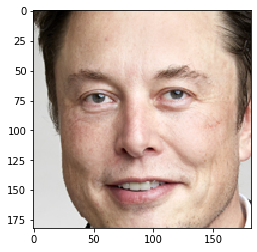

In [20]:
prediction('elon.jpg', model)

Male with 93.61% confidence.


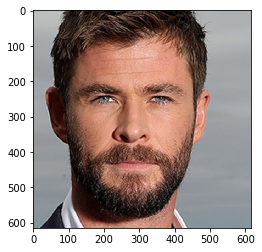

In [21]:
prediction('chris_hemsworth.jpg', model)

Female with 98.27% confidence.


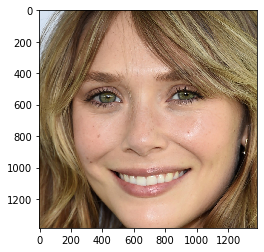

In [22]:
prediction('elizabeth_olsen.jpg', model)

Female with 99.04% confidence.


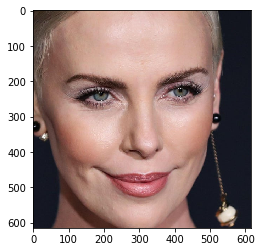

In [23]:
prediction('charlize_theron.jpg', model)